![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from ECommerce Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.


## Basics of EDA

Here are a few things that we are looking for in the invoice / transaction data:

1. Were there any negative totals? If so why?
2. What percentage of the purchases actually contained multiple items?
3. What is the spread of purchases by customer ID? Do we have a few customers whose behavior may drive recommendations in a way that doesn't fit the average customer?
4. Where there any purchases that were VERY large? If so why? Do we want to include these values to train model behavior?
5. Is there any missing data that we need to scrub?


In [12]:
%reload_kedro

2021-09-18 21:49:34,073 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-09-18 21:49:34,120 - root - INFO - ** Kedro project productrec
2021-09-18 21:49:34,121 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-09-18 21:49:34,134 - root - INFO - Registered line magic `run_viz`


In [13]:
import pandas as pd
import numpy as np
import random
import scipy.sparse
from matplotlib import pyplot as plt
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [45]:
transactions = catalog.load("brazillian_kaggle_order_data")
products = catalog.load("brazillian_kaggle_product_data")
customers = catalog.load("brazillian_kaggle_customer_data")

2021-09-18 22:04:54,905 - kedro.io.data_catalog - INFO - Loading data from `brazillian_kaggle_order_data` (CSVDataSet)...
2021-09-18 22:04:56,775 - kedro.io.data_catalog - INFO - Loading data from `brazillian_kaggle_product_data` (CSVDataSet)...
2021-09-18 22:04:57,111 - kedro.io.data_catalog - INFO - Loading data from `brazillian_kaggle_customer_data` (CSVDataSet)...


In [46]:
transactions['order_id'] = transactions.order_id.astype(str)
transactions['product_id'] = transactions.product_id.astype(str)
transactions.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [47]:
products['product_id'] = products.product_id.astype(str)
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [49]:
customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [50]:
customers = customers[["customer_id", "order_id", "order_purchase_timestamp"]]
customers['order_id'] = customers.order_id.astype(str)
customers['customer_id'] = customers.customer_id.astype(str)

customers.head()

/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [54]:
print(transactions.dtypes)
print(customers.dtypes)
transactions = transactions.merge(customers, on='order_id')

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object
customer_id                 object
order_id                    object
order_purchase_timestamp    object
dtype: object


# Checking for missing data

In [55]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 112650


order_id                    0
order_item_id               0
product_id                  0
seller_id                   0
shipping_limit_date         0
price                       0
freight_value               0
customer_id                 0
order_purchase_timestamp    0
dtype: int64

There are 98666 unique transactions

Here are the counts of transactions ordered from largest to smallest
[21 20 20 ...  1  1  1]

And a graph of what the curve looks like:


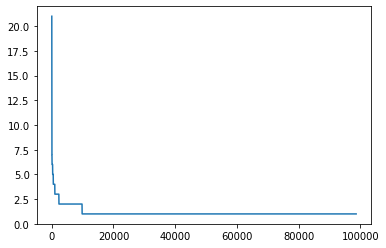

In [56]:
transaction_counts = transactions['order_id'].value_counts().to_numpy()
print('There are', len(transaction_counts), 'unique transactions\n')
print('Here are the counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

# User Interactions

Let's take a look at how many unique customers are included in this dataset

There are 98666 unique customers

Here are the counts of transactions per customer ordered from largest to smallest
[21 20 20 ...  1  1  1]

And a graph of what the curve looks like:


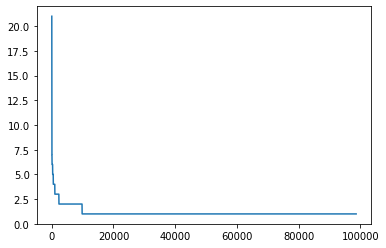

In [57]:
user_counts = transactions['customer_id'].value_counts().to_numpy()
print('There are', len(user_counts), 'unique customers\n')
print('Here are the counts of transactions per customer ordered from largest to smallest')
print(user_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(user_counts) 
plt.show()

In [58]:
transactions.groupby(['customer_id'])['customer_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,customer_id,count
97220,fc3d1daec319d62d49bfb5e1f83123e9,21
73568,be1b70680b9f9694d8c70f41fa3dc92b,20
73311,bd5d39761aa56689a265d95d8d32b8be,20
67106,adb32467ecc74b53576d9d13a5a55891,15
6456,10de381f8a8d23fff822753305f71cae,15
64553,a7693fba2ff9583c78751f2b66ecab9d,14
82722,d5f2b3f597c7ccafbb5cac0bcc3d6024,14
48195,7d321bd4e8ba1caf74c4c1aabd9ae524,13
22924,3b54b5978e9ace64a63f90d176ffb158,12
84626,daf15f1b940cc6a72ba558f093dc00dd,12


It looks like "-1" is used when the customer is unknown. Let's take a look at the UserId with the very high count of items in the transactions.

In [59]:
transactions[transactions.customer_id == "fc3d1daec319d62d49bfb5e1f83123e9"].groupby(transactions.order_id).count()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_purchase_timestamp
order_id,,,,,,,,,
8272b63d03f5f79c56e9e4120aec44ef,21,21,21,21,21,21,21,21,21


It appears that there are a lot of different transactions, so probably not just the same thing being purchased over and over. Not really sure what to do with this at the moment.

# Transactions over Time

Now we need to look at the number of items purchased each day to see if there is anything interesting that pops out.

In [60]:
from datetime import datetime

datetime_object = datetime.strptime('2017-10-02 10:56:33', '%Y-%m-%d %H:%M:%S')

In [61]:
from datetime import datetime

datetime_object = datetime.strptime('Mon Feb 12 04:26:00 IST 2018', '%a %b %d %H:%M:%S IST %Y')

def func(date):
    temp = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
    return temp.strftime('%Y%m%d')

transactions['datetime'] = transactions.apply(lambda x: func(x.order_purchase_timestamp), axis=1)


<AxesSubplot:>

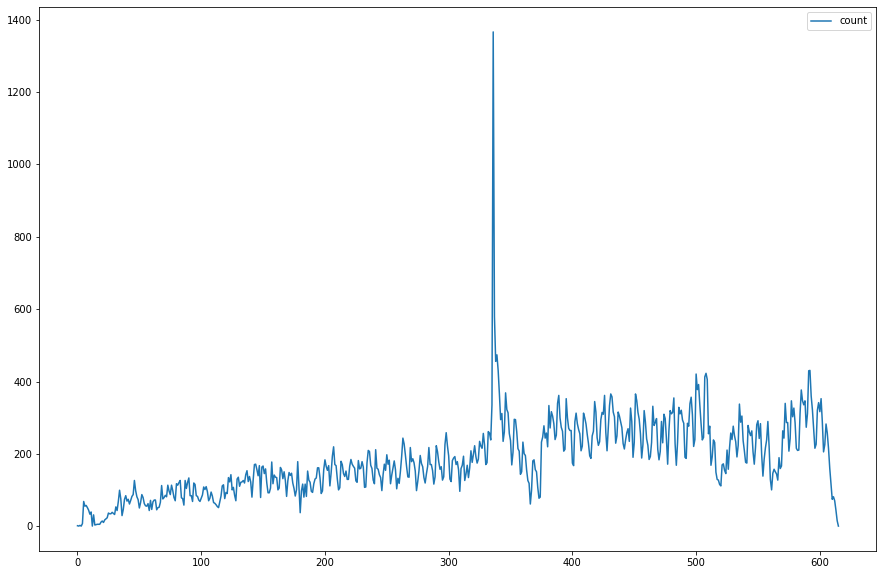

In [62]:
transactions.groupby(['datetime'])['datetime'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['datetime'], ascending=True) \
                             .plot(figsize=(15,10))

# Checking Invoice Totals

We need to make sure all the invoice totals that we're using are positive - this keeps us from using invoices that captured customer returned items.

<AxesSubplot:xlabel='order_id'>

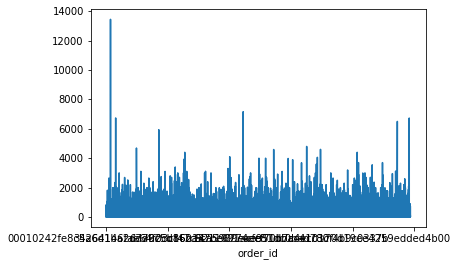

In [63]:
totals = transactions.groupby(transactions.order_id)['price'].sum()
totals.plot()

In [64]:
totals.sort_values(ascending=False)

order_id
03caa2c082116e1d31e67e9ae3700499    13440.00
736e1922ae60d0d6a89247b851902527     7160.00
0812eb902a67711a1cb742b3cdaa65ae     6735.00
fefacc66af859508bf1a7934eab1e97f     6729.00
f5136e38d1a14a4dbd87dff67da82701     6499.00
                                      ...   
38bcb524e1c38c2c1b60600a80fc8999        2.90
e8bbc1d69fee39eee4c72cb5c969e39d        2.29
f1d5c2e6867fa93ceee9ef9b34a53cbf        2.20
3ee6513ae7ea23bdfab5b9ab60bffcb5        0.85
6e864b3f0ec71031117ad4cf46b7f2a1        0.85
Name: price, Length: 98666, dtype: float64

In [65]:
print('There are', len(transactions[transactions.price < 0]), 'negative prices')
transactions[transactions.price < 0].head()

There are 0 negative quantities


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_purchase_timestamp,datetime


In [66]:
q = transactions["price"].quantile(0.98)
# transactions = transactions[transactions["price"] < q]
print(q)

619.0


We will need to remove transactions that only included a single item

In [72]:
minimum_order_size = 2
order_group = transactions.loc[:, ['order_id', 'product_id']].groupby('order_id').count()
 
multi_order = order_group[(order_group.product_id >= minimum_order_size)].count()
single_order = order_group[(order_group.product_id < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['product_id'])
print('Orders with less than',minimum_order_size,'products:',single_order['product_id'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.product_id >= minimum_order_size)].index.tolist()

filtered_df = transactions[transactions['order_id'].isin(order_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

filtered_df['quantity'] = 1

Orders with at least 2 products: 9803
Orders with less than 2 products: 88863
Original dataframe length: 112650
Filtered dataframe length: 23787


Well it looks like this entire dataset has transactions with multiple products. No need to filter out transactions with only a single.

# Data Sparcity

Let's take a look at the sparcity of the data. This will tell us how many products were purchased across multiple orders. This is directly related to how well a recommendation system can be trained.

In [75]:
transaction_list = list(np.sort(filtered_df.order_id.unique())) # Get our unique customers
item_list = list(filtered_df.product_id.unique()) # Get our unique products that were purchased
quantity_list = list(filtered_df.quantity) # All of our purchases

cols = filtered_df.order_id.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = filtered_df.product_id.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

In [76]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.98303967090008

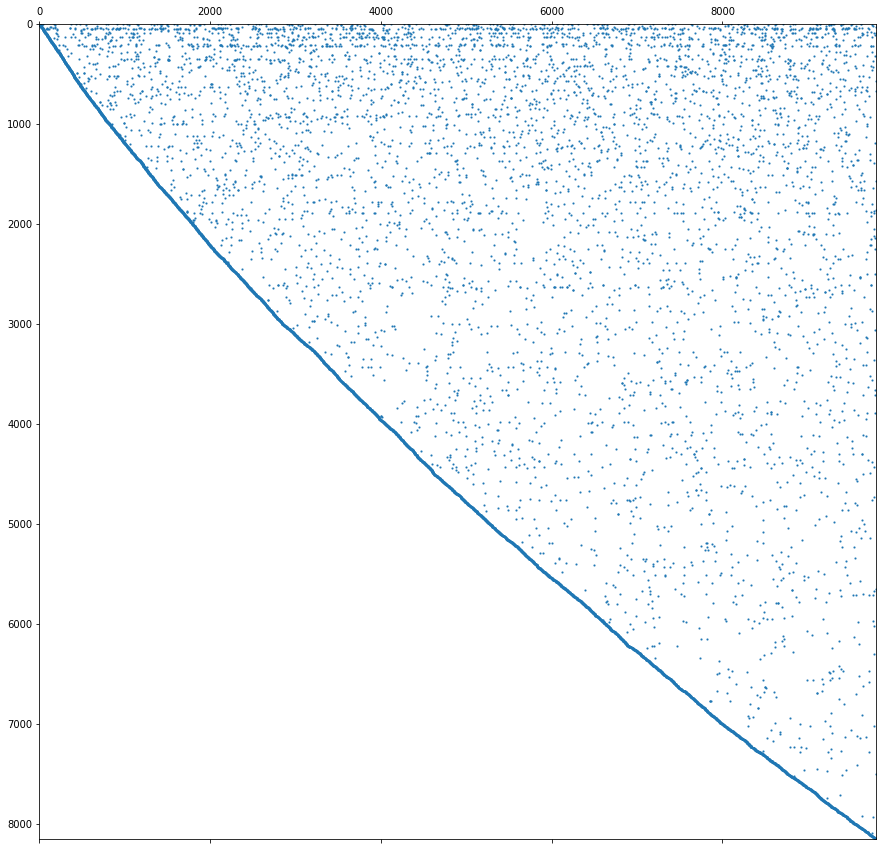

In [77]:
plt.figure(figsize=(15, 15))
plt.spy(purchases_sparse, markersize=1, aspect='auto')

# Storing Interim Data

Now that we have the data cleaned up a bit and formatted correctly, we can save it to an interim file to be picked up by the model training algorithm.

In [82]:
catalog.save("brazillian_transactions", filtered_df[["order_id", "product_id", "price", "quantity"]])

products["description"] = products["product_category_name"] + str(products["product_description_lenght"])

catalog.save("brazillian_products", products[["product_id", "description"]])

2021-09-18 22:23:59,018 - kedro.io.data_catalog - INFO - Saving data to `brazillian_transactions` (CSVDataSet)...
2021-09-18 22:23:59,121 - kedro.io.data_catalog - INFO - Saving data to `brazillian_products` (CSVDataSet)...
